In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func


In [5]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [6]:
# Declare a Base using `automap_base()`
Base = automap_base()
# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)

/var/folders/c8/jzb_kqq53379zk0mw9gz8rvr0000gn/T/ipykernel_12016/3601434573.py:4: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [7]:
# Print all of the classes mapped to the Base
Base.classes.keys()

['measurement', 'station']

In [8]:
# Assign the measurement class to a variable called `Measurement` and
# the station class to a variable called `Station`
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create a session
session = Session(engine)

In [10]:
print(Measurement.__table__.columns)
print(Station.__table__.columns)

ReadOnlyColumnCollection(measurement.id, measurement.station, measurement.date, measurement.prcp, measurement.tobs)
ReadOnlyColumnCollection(station.id, station.station, station.name, station.latitude, station.longitude, station.elevation)


## Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(recent_date)

('2017-08-23',)


In [12]:
# Check what recent_date holds
print("Recent Date Object:", recent_date)

# If it's a Row object, print the first element
if isinstance(recent_date, tuple) or isinstance(recent_date, sqlalchemy.engine.row.Row):
    print("First Element of Recent Date:", recent_date[0])
    
# Convert to Timestamp
recent_date_dt = pd.to_datetime(recent_date[0])
print("Converted Recent Date:", recent_date_dt)
print("Type of Converted Date:", type(recent_date_dt))

Recent Date Object: ('2017-08-23',)
First Element of Recent Date: 2017-08-23
Converted Recent Date: 2017-08-23 00:00:00
Type of Converted Date: <class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.

# Calculate the date one year from the last date in data set.
year_ago = recent_date_dt - pd.Timedelta(days=365)
year_ago_str = year_ago.strftime('%Y-%m-%d')
# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= year_ago_str).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=['date', 'prcp'])
print(precipitation_df.head())

# Sort the dataframe by date 
precipitation_df_dated = precipitation_df.sort_values(by='date')
print(precipitation_df_dated.head())


         date  prcp
0  2016-08-23  0.00
1  2016-08-23  0.15
2  2016-08-23  0.05
3  2016-08-23   NaN
4  2016-08-23  0.02
         date  prcp
0  2016-08-23  0.00
1  2016-08-23  0.15
2  2016-08-23  0.05
3  2016-08-23   NaN
4  2016-08-23  0.02


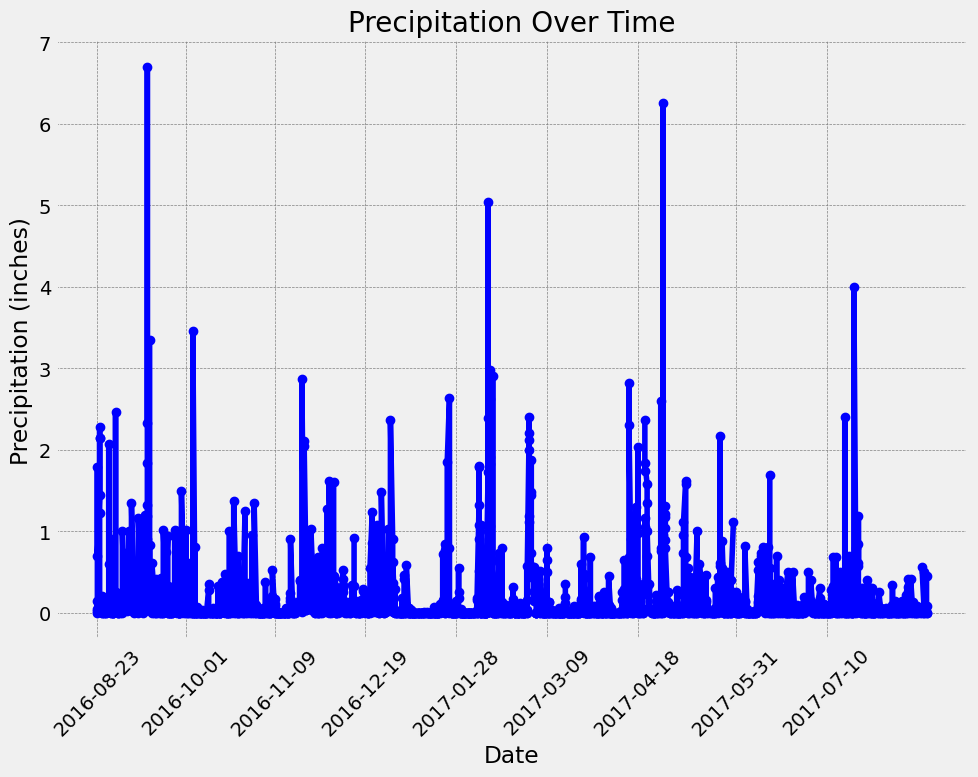

In [14]:
# Plot the data using Pandas' built-in plotting
plt.figure(figsize=(10, 8))  # Width of 10, Height of 8

# Plot the data
plt.plot(precipitation_df_dated['date'], precipitation_df_dated['prcp'], marker='o', linestyle='-', color='blue')

# Add titles and labels
plt.title('Precipitation Over Time')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')

# Set x-ticks to show only every 10th date
plt.xticks(ticks=precipitation_df_dated['date'][::250], rotation=45)  # Adjust 10 to whatever interval you prefer

# Show grid
plt.grid(visible=True, color='gray', linestyle='--', linewidth=0.5)

# Show the plot
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlap
plt.show()

In [15]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = precipitation_df_dated['prcp'].describe()
print(summary_stats)

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64


# Exploratory Station Analysis

In [16]:
# Design a query to calculate the total number of stations in the dataset
station_count = session.query(func.count(Station.id)).scalar()
print(station_count)

9


In [17]:
print(Measurement.__table__.columns)
print(Station.__table__.columns)

ReadOnlyColumnCollection(measurement.id, measurement.station, measurement.date, measurement.prcp, measurement.tobs)
ReadOnlyColumnCollection(station.id, station.station, station.name, station.latitude, station.longitude, station.elevation)


In [18]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Station.station, Station.name, func.count(Measurement.id)).\
    filter(Measurement.station == Station.station).\
    group_by(Station.station).\
    order_by(func.count(Measurement.id).desc()).all()
for station_id, station_name, count in active_stations:
    print(f"Station ID: {station_id}, Station Name: {station_name}, Count: {count}")

Station ID: USC00519281, Station Name: WAIHEE 837.5, HI US, Count: 2772
Station ID: USC00519397, Station Name: WAIKIKI 717.2, HI US, Count: 2724
Station ID: USC00513117, Station Name: KANEOHE 838.1, HI US, Count: 2709
Station ID: USC00519523, Station Name: WAIMANALO EXPERIMENTAL FARM, HI US, Count: 2669
Station ID: USC00516128, Station Name: MANOA LYON ARBO 785.2, HI US, Count: 2612
Station ID: USC00514830, Station Name: KUALOA RANCH HEADQUARTERS 886.9, HI US, Count: 2202
Station ID: USC00511918, Station Name: HONOLULU OBSERVATORY 702.2, HI US, Count: 1979
Station ID: USC00517948, Station Name: PEARL CITY, HI US, Count: 1372
Station ID: USC00518838, Station Name: UPPER WAHIAWA 874.3, HI US, Count: 511


In [19]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = 'USC00519281' 

# Min, max, and average temperatures for the most active station
temperature_stats = session.query(
    func.min(Measurement.tobs), 
    func.max(Measurement.tobs), 
    func.avg(Measurement.tobs)
).filter(Measurement.station == most_active_station_id).all()

# Print the results
print(f"Temperature Stats for Station ID {most_active_station_id}:")
print(f"Min Temperature: {temperature_stats[0][0]}")
print(f"Max Temperature: {temperature_stats[0][1]}")
print(f"Avg Temperature: {temperature_stats[0][2]}")

Temperature Stats for Station ID USC00519281:
Min Temperature: 54.0
Max Temperature: 85.0
Avg Temperature: 71.66378066378067


In [20]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
year_ago = recent_date_dt - pd.Timedelta(days=365)
year_ago_str = year_ago.strftime('%Y-%m-%d')
last_year_tobs = session.query(Measurement.tobs).filter(
    Measurement.station == most_active_station_id,
    Measurement.date >= year_ago_str
).all()

In [21]:
print(type(most_active_station_id), type(year_ago))

<class 'str'> <class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [22]:
last_year_tobs_df = pd.DataFrame(last_year_tobs, columns=['tobs'])
print(last_year_tobs_df.head())

   tobs
0  77.0
1  77.0
2  80.0
3  80.0
4  75.0


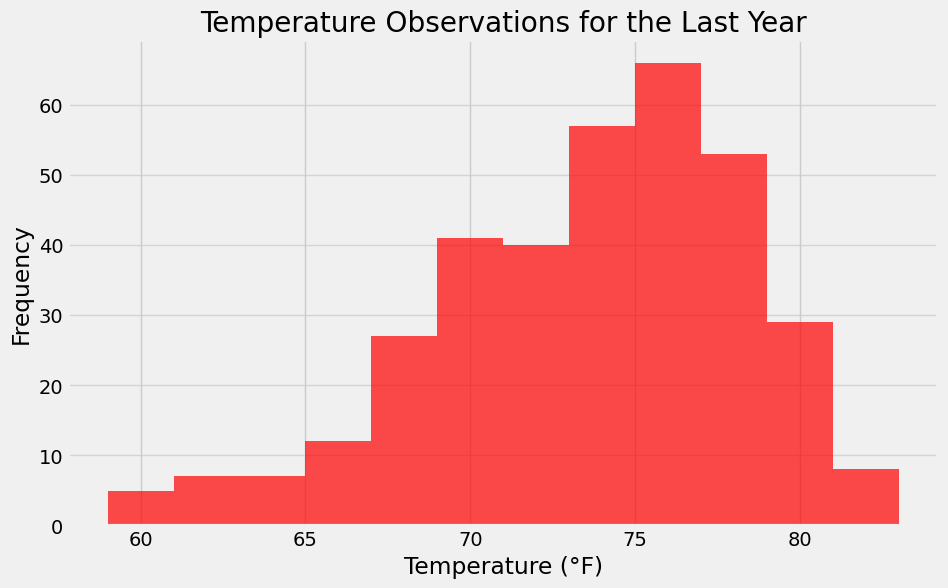

In [23]:
plt.figure(figsize=(10, 6))
plt.hist(last_year_tobs_df['tobs'], bins=12, color='red' \
'', alpha=0.7)
plt.title('Temperature Observations for the Last Year')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

## Close Session

In [24]:
# Close Session
session.close()
